In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

In [2]:
train_data = pd.read_csv('digit-recognizer/train.csv')
test_data = pd.read_csv('digit-recognizer/test.csv')
sample_submission = pd.read_csv('digit-recognizer/sample_submission.csv')

sc = StandardScaler()
ohe = OneHotEncoder()

test_data = np.asfarray(test_data).reshape(len(test_data),28,28,1)
train_data_without_labels = sc.fit_transform(train_data.iloc[:,1:].values)
labels = ohe.fit_transform(train_data.iloc[:,0:1].values).toarray()

data_train, data_val, label_train, label_val = train_test_split(train_data_without_labels, labels, test_size = 0.3)

data_train = np.asfarray(data_train).reshape(len(data_train),28,28,1)
data_val = np.asfarray(data_val).reshape(len(data_val),28,28,1)

In [3]:
class DigitModel(keras.Model):
    def __init__(self):
        
        super().__init__()
        self.conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')
        self.conv2 = layers.Conv2D(64, 3, activation='relu')
        self.maxpool1 = layers.MaxPooling2D(2,2)
        self.dense1 = layers.Dense(65, activation='relu')
        self.conv3 = layers.Conv2D(64, (3,3), activation='relu')
        self.maxpool2 = layers.MaxPooling2D(2,2)
        self.flatten1 = layers.Flatten(input_shape=(data_train.shape[1:]))
        self.dense2 = layers.Dense(128, activation='relu')
        self.dense3 = layers.Dense(256, activation='relu')
        self.dense4 = layers.Dense(512, activation='relu')
        self.dense5 = layers.Dense(10, activation='softmax')
        
    def call(self, inputs):
        
        x1 = self.conv1(inputs)
        x2 = self.conv2(x1)
        x3 = self.maxpool1(x2)
        x4 = self.dense1(x3)
        x5 = self.conv3(x4)
        x6 = self.maxpool2(x5)
        x7 = self.flatten1(x6)
        x8 = self.dense2(x7)
        x9 = self.dense3(x8)
        x10 = self.dense4(x9)
        x11 = self.dense5(x10)
        
        return x11


In [4]:
model = DigitModel()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [5]:
filepath = 'best_model.tf'

checkpoint = ModelCheckpoint(
    filepath=filepath,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

callbacks = [checkpoint]

In [6]:
history = model.fit(
    data_train, 
    label_train, 
    validation_data = (data_val, label_val), 
    epochs=10, 
    batch_size=64,
    callbacks=callbacks
)

Epoch 1/10
460/460 [==============================] - 52s 111ms/step - loss: 0.2183 - accuracy: 0.9303 - val_loss: 0.0814 - val_accuracy: 0.9763

Epoch 00001: val_accuracy improved from -inf to 0.97635, saving model to best_model.tf
INFO:tensorflow:Assets written to: best_model.tf\assets
Epoch 2/10
460/460 [==============================] - 50s 108ms/step - loss: 0.0574 - accuracy: 0.9824 - val_loss: 0.0652 - val_accuracy: 0.9804

Epoch 00002: val_accuracy improved from 0.97635 to 0.98040, saving model to best_model.tf
INFO:tensorflow:Assets written to: best_model.tf\assets
Epoch 3/10
460/460 [==============================] - 52s 113ms/step - loss: 0.0396 - accuracy: 0.9879 - val_loss: 0.0742 - val_accuracy: 0.9795

Epoch 00003: val_accuracy did not improve from 0.98040
Epoch 4/10
460/460 [==============================] - 50s 109ms/step - loss: 0.0299 - accuracy: 0.9907 - val_loss: 0.0530 - val_accuracy: 0.9867

Epoch 00004: val_accuracy improved from 0.98040 to 0.98675, saving model

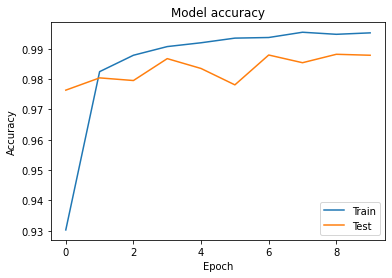

In [7]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

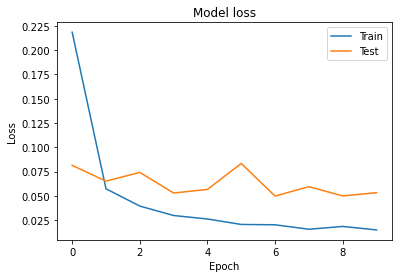

In [8]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper right') 
plt.show()

In [9]:
best_model = load_model(filepath)

In [10]:
test_data_pred = model.predict(test_data)

pred = list()

for i in range(len(test_data_pred)):
    pred.append(np.argmax(test_data_pred[i]))
    
submission_data = []

for i in range(0, len(pred)):
    submission_data.append([i+1, pred[i]])

In [11]:
submit_net = pd.DataFrame(submission_data)
submit_net = submit_net.rename(columns={0: "ImageId", 1: "Label"})

submit_net.to_csv("submit_model_class.csv", index=False)